<a href="https://colab.research.google.com/github/HaiderAli-Awan/Encryption-and-Decryption-Cesar-Cipher/blob/main/Gender_Detection%20using%20OpenCV%20for%20single%20Face%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

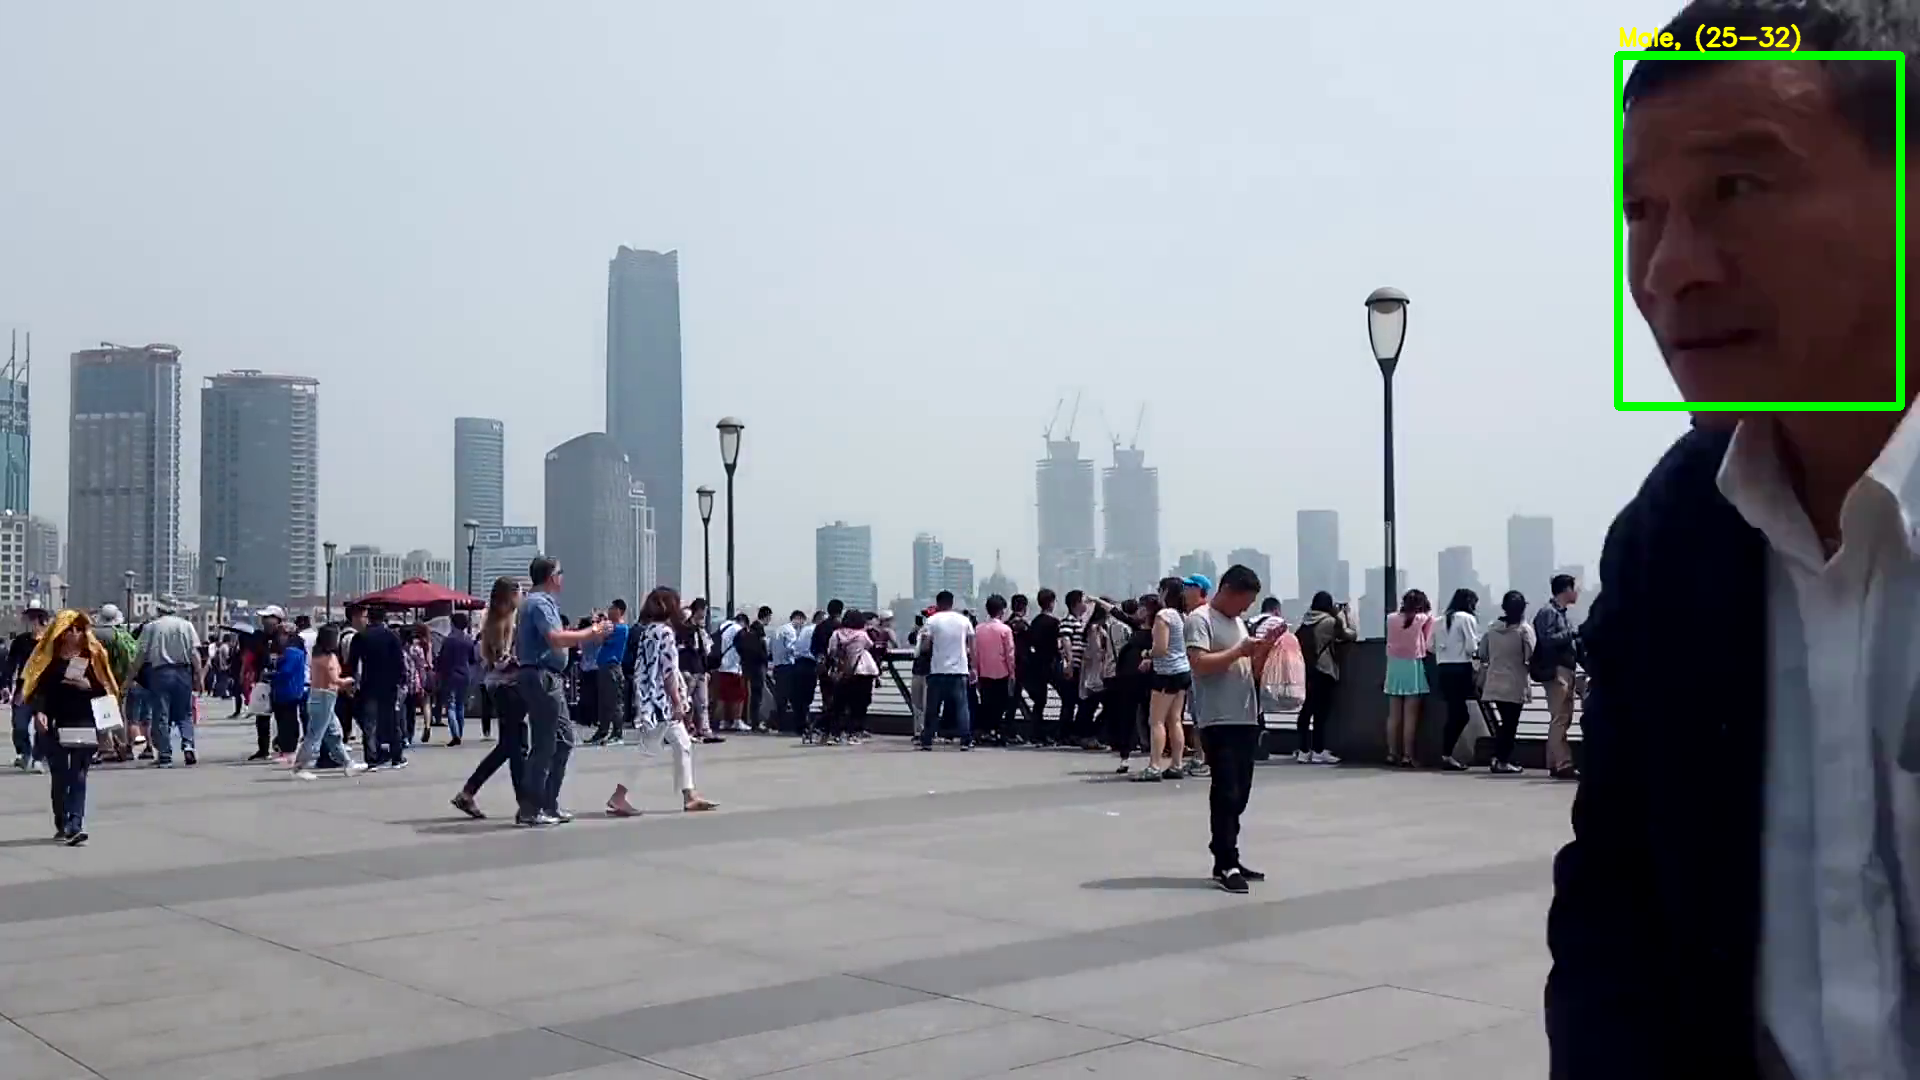

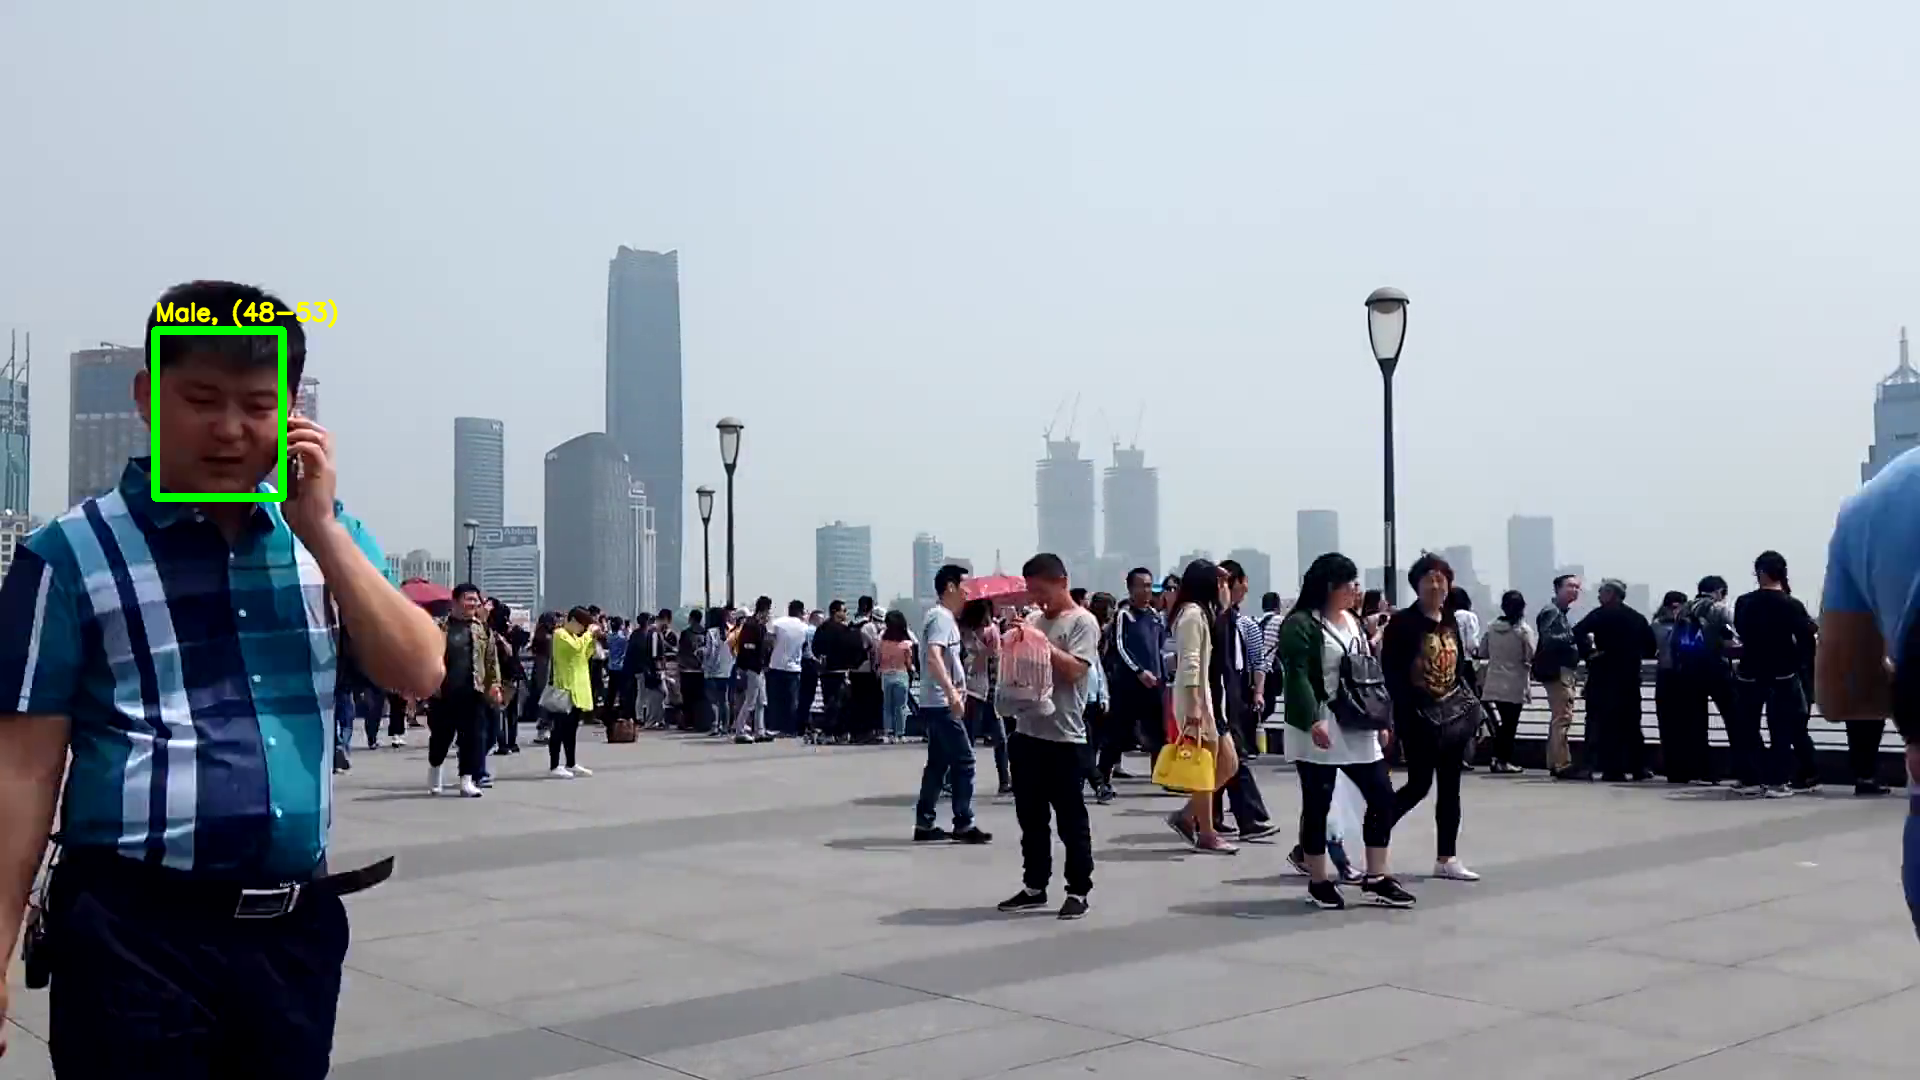

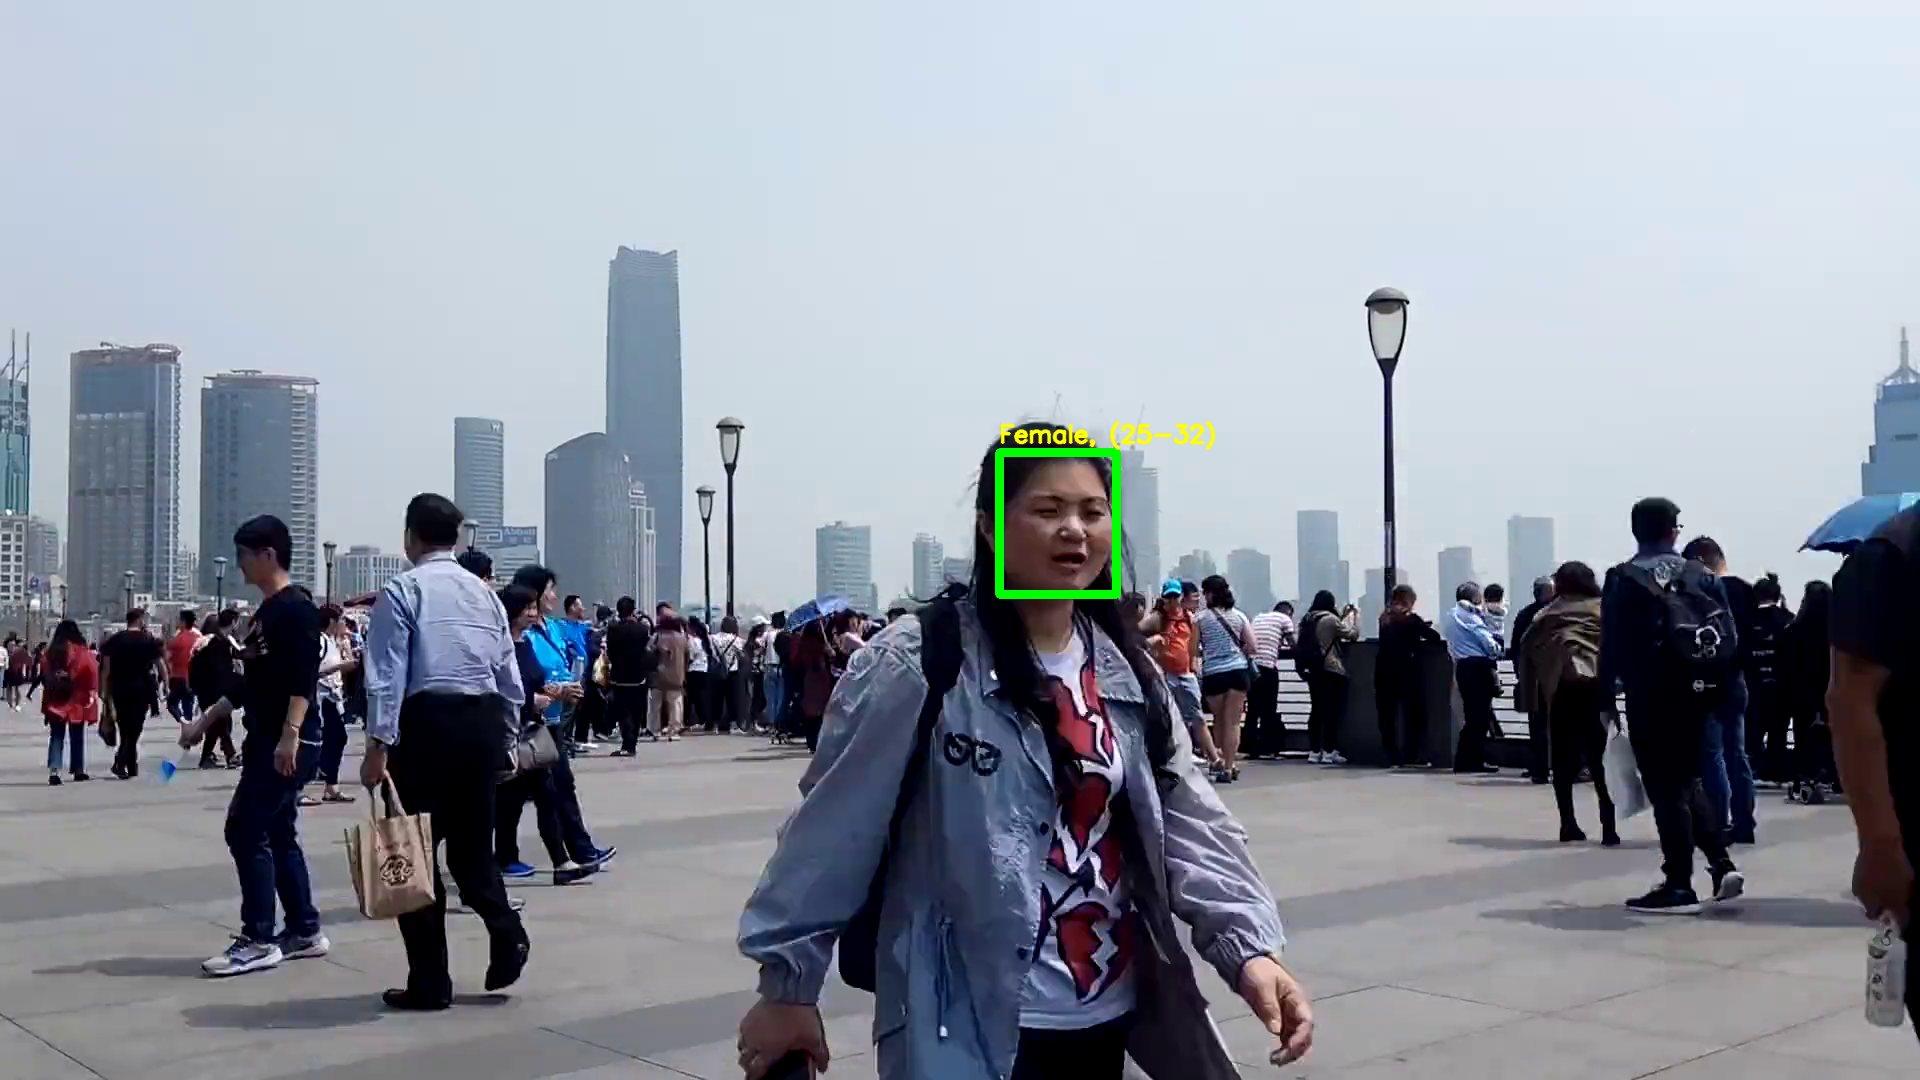

Statistics have been saved to output_stats.txt


In [ ]:
import cv2
import math
import argparse
import numpy as np
from collections import defaultdict
from google.colab import files
import sys
from google.colab.patches import cv2_imshow

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, faceBoxes


#parser = argparse.ArgumentParser()
#args = parser.parse_args(args=sys.argv[1:])
#parser.add_argument('--video', help='Path to input video file', default='/content/vedio.mp4')
#parser.add_argument('--output', help='Path to output text file', default='output_stats.txt')
#args = parser.parse_args()
#***
args_dict = {
    'video': '/content/drive/MyDrive/vedio.mp4',  # Replace with your video path
    'output': 'output_stats.txt'
}

# **Create a Namespace object from the dictionary**
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args = Args(**args_dict)

face_proto = "/content/drive/MyDrive/Pre-trained Models/opencv_face_detector.pbtxt"
face_model = "/content/drive/MyDrive/Pre-trained Models/opencv_face_detector_uint8.pb"
ageProto = "/content/drive/MyDrive/Pre-trained Models/age_deploy.prototxt"
ageModel = "/content/drive/MyDrive/Pre-trained Models/age_net.caffemodel"
genderProto = "/content/drive/MyDrive/Pre-trained Models/gender_deploy.prototxt"
genderModel = "/content/drive/MyDrive/Pre-trained Models/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

faceNet = cv2.dnn.readNet(face_model, face_proto)
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

video = cv2.VideoCapture(args.video if args.video else 0)

padding = 20
frame_interval = 5  # Process every 5th frame
frame_count = 0
stats = defaultdict(lambda: {'count': 0, 'total_age': 0, 'age_distribution': defaultdict(int)})

while True:
    hasFrame, frame = video.read()
    if not hasFrame:
        break

    frame_count += 1
    if frame_count % frame_interval != 0:
        continue

    resultImg, faceBoxes = highlightFace(faceNet, frame)

    for faceBox in faceBoxes:
        face = frame[max(0, faceBox[1]-padding):
                     min(faceBox[3]+padding, frame.shape[0]-1),
                     max(0, faceBox[0]-padding):
                     min(faceBox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        age_value = int(age[1:-1].split('-')[0])  # Take the lower bound of the age range

        stats[gender]['count'] += 1
        stats[gender]['total_age'] += age_value
        stats[gender]['age_distribution'][age] += 1

        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)

        cv2_imshow(resultImg)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

# Generate and save text output
with open(args.output, 'w') as f:
    f.write("Gender and Age Detection Statistics\n")
    f.write("==================================\n\n")

    total_count = sum(data['count'] for data in stats.values())
    f.write(f"Total faces detected: {total_count}\n")
    f.write(f"Total Males: {stats['Male']['count']}\n")
    f.write(f"Total Females: {stats['Female']['count']}\n\n")

    for gender, data in stats.items():
        count = data['count']
        avg_age = data['total_age'] / count if count > 0 else 0
        percentage = (count / total_count) * 100 if total_count > 0 else 0

        f.write(f"{gender} Statistics:\n")
        f.write(f"  Count: {count} ({percentage:.2f}%)\n")
        f.write(f"  Average Age: {avg_age:.2f}\n")
        f.write("  Age Distribution:\n")

        for age_range, age_count in sorted(data['age_distribution'].items()):
            age_percentage = (age_count / count) * 100 if count > 0 else 0
            f.write(f"    {age_range}: {age_count} ({age_percentage:.2f}%)\n")

        f.write("\n")

print(f"Statistics have been saved to {args.output}")

In [ ]:
import cv2
import math
import argparse
import numpy as np
from collections import defaultdict
from google.colab import files
import sys
from google.colab.patches import cv2_imshow

def highlight_face(net, frame, conf_threshold=0.7):

    frame_opencv_dnn = frame.copy()
    frame_height = frame_opencv_dnn.shape[0]
    frame_width = frame_opencv_dnn.shape[1]

    blob = cv2.dnn.blobFromImage(frame_opencv_dnn, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()
    face_boxes = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_width)
            face_boxes.append([x1, y1, x2, y2])
            cv2.rectangle(frame_opencv_dnn, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return frame_opencv_dnn, face_boxes

def predict_age_gender(age_net, gender_net, face, model_mean_values, age_list, gender_list):

    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), model_mean_values, swapRB=False)

    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender = gender_list[gender_preds[0].argmax()]

    age_net.setInput(blob)
    age_preds = age_net.forward()
    age = age_list[age_preds[0].argmax()]
    age_value = int(age[1:-1].split('-')[0])

    return gender, age_value

def process_video(video_path, output_path, face_proto, face_model, age_proto, age_model, gender_proto, gender_model, frame_interval=5):


    face_net = cv2.dnn.readNet(face_model, face_proto)
    age_net = cv2.dnn.readNet(age_model, age_proto)
    gender_net = cv2.dnn.readNet(gender_model, gender_proto)

    model_mean_values = (78.4263377603, 87.7689143744, 114.895847746)
    age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    gender_list = ['Male', 'Female']

    video = cv2.VideoCapture(video_path)

    padding = 20
    frame_count = 0
    stats = defaultdict(lambda: {'count': 0, 'total_age': 0, 'age_distribution': defaultdict(int)})

    while True:
        has_frame, frame = video.read()
        if not has_frame:
            break

        frame_count += 1
        if frame_count % frame_interval != 0:
            continue

        result_img, face_boxes = highlight_face(face_net, frame)

        for face_box in face_boxes:
            face = frame[max(0, face_box[1]-padding):min(face_box[3]+padding, frame.shape[0]-1),
                          max(0, face_box[0]-padding):min(face_box[2]+padding, frame.shape[1]-1)]

            gender, age_value = predict_age_gender(age_net, gender_net, face, model_mean_values, age_list, gender_list)

            stats[gender]['count'] += 1
            stats[gender]['total_age'] += age_value
            stats[gender]['age_distribution'][age] += 1

            cv2.putText(result_img, f'{gender}, {age}', (face_box[0], face_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)

        cv2_imshow(result_img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()

# Generate and save text output
with open(args.output, 'w') as f:
    f.write("Gender and Age Detection Statistics\n")
    f.write("==================================\n\n")

    total_count = sum(data['count'] for data in stats.values())
    f.write(f"Total faces detected: {total_count}\n")
    f.write(f"Total Males: {stats['Male']['count']}\n")
    f.write(f"Total Females: {stats['Female']['count']}\n\n")

    for gender, data in stats.items():
        count = data['count']
        avg_age = data['total_age'] / count if count > 0 else 0
        percentage = (count / total_count) * 100 if total_count > 0 else 0

        f.write(f"{gender} Statistics:\n")
        f.write(f"  Count: {count} ({percentage:.2f}%)\n")
        f.write(f"  Average Age: {avg_age:.2f}\n")
        f.write("  Age Distribution:\n")

        for age_range, age_count in sorted(data['age_distribution'].items()):
            age_percentage = (age_count / count) * 100 if count > 0 else 0
            f.write(f"    {age_range}: {age_count} ({age_percentage:.2f}%)\n")

        f.write("\n")

print(f"Statistics have been saved to {args.output}")

Statistics have been saved to output_stats.txt


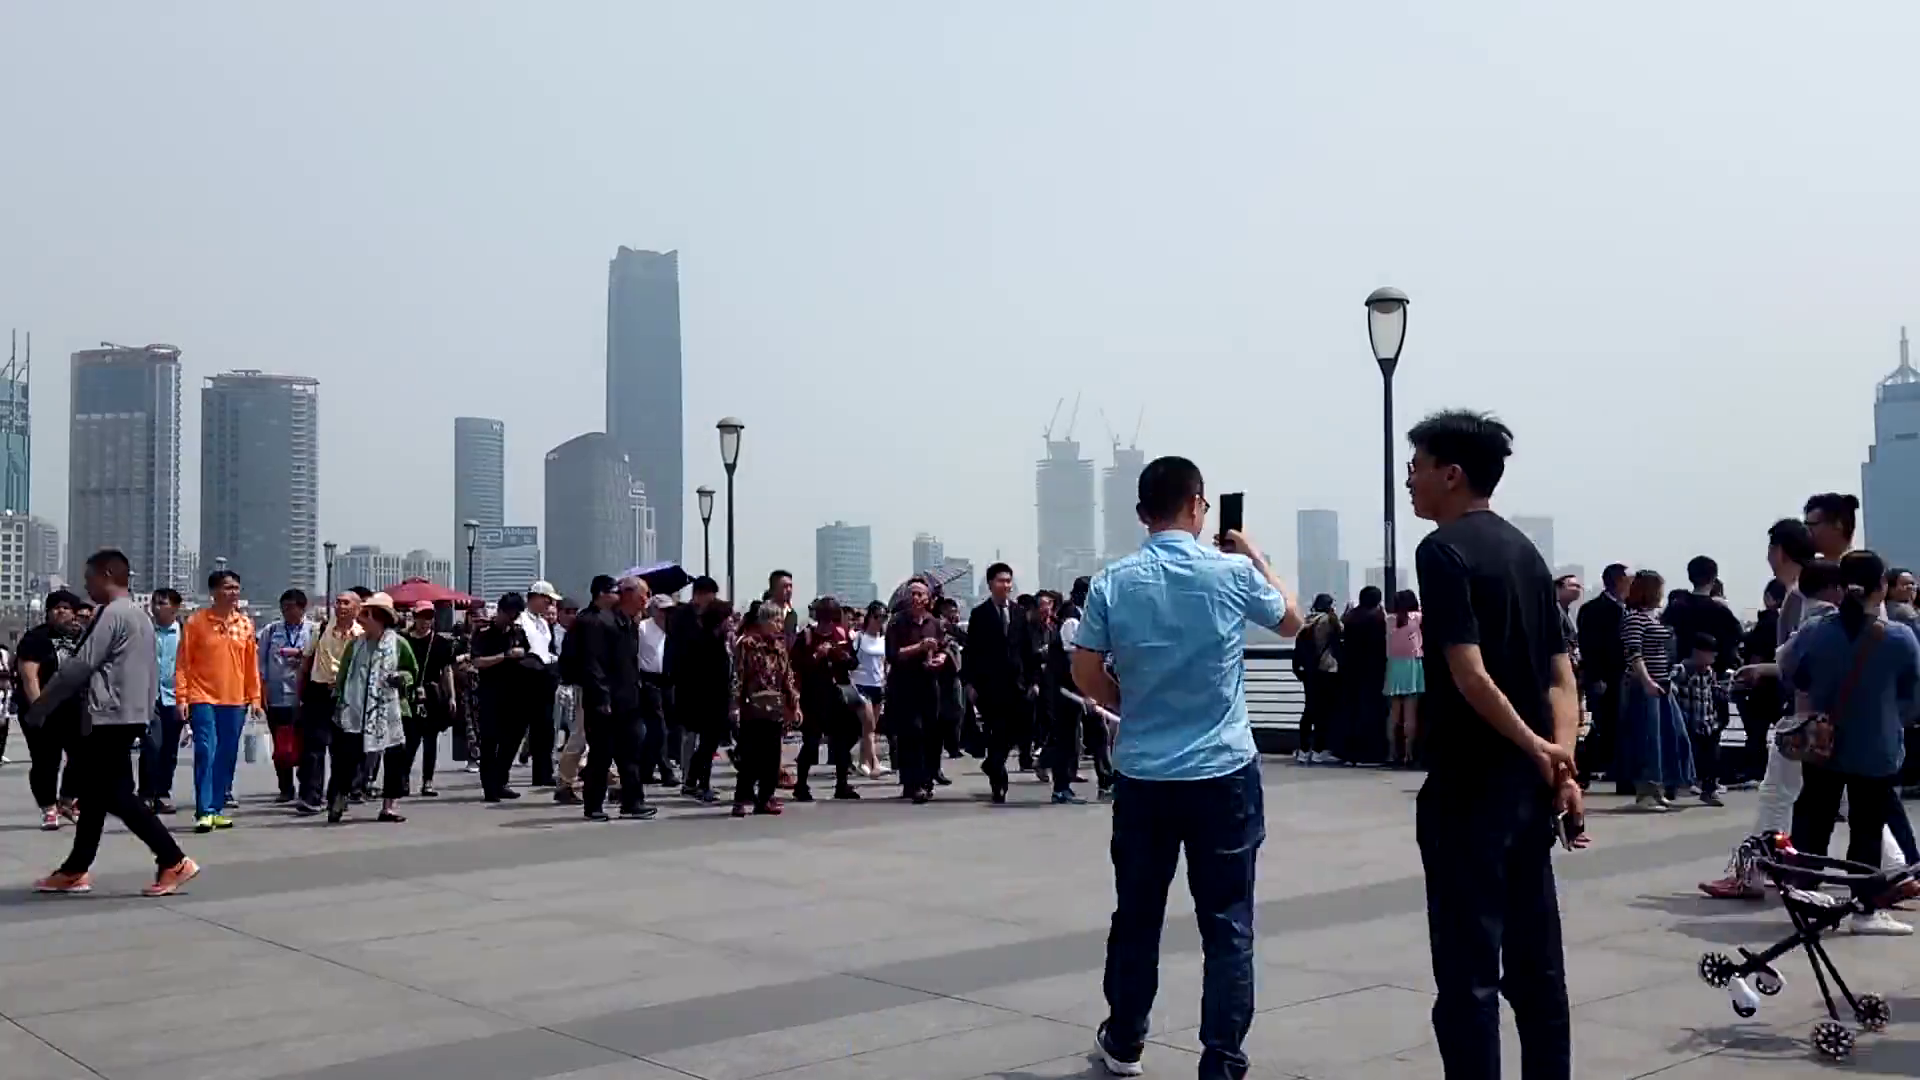

In [ ]:
import cv2
import math
import argparse
import numpy as np
from collections import defaultdict
from google.colab.patches import cv2_imshow

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            # Draw rectangles around the detected faces
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, faceBoxes

# Arguments as a dictionary
args_dict = {
    'video': '/content/drive/MyDrive/vedio.mp4',  # Replace with your video path
    'output': 'output_stats.txt'
}

# Create a Namespace-like class to simulate argparse functionality
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args = Args(**args_dict)

# Model paths
face_proto = "/content/drive/MyDrive/Pre-trained Models/opencv_face_detector.pbtxt"
face_model = "/content/drive/MyDrive/Pre-trained Models/opencv_face_detector_uint8.pb"
ageProto = "/content/drive/MyDrive/Pre-trained Models/age_deploy.prototxt"
ageModel = "/content/drive/MyDrive/Pre-trained Models/age_net.caffemodel"
genderProto = "/content/drive/MyDrive/Pre-trained Models/gender_deploy.prototxt"
genderModel = "/content/drive/MyDrive/Pre-trained Models/gender_net.caffemodel"

# Age and gender labels
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load the models
faceNet = cv2.dnn.readNet(face_model, face_proto)
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

# Open video file
video = cv2.VideoCapture(args.video if args.video else 0)

padding = 20
frame_interval = 5  # Process every 5th frame to reduce computational load
frame_count = 0
stats = defaultdict(lambda: {'count': 0, 'total_age': 0, 'age_distribution': defaultdict(int)})

while True:
    hasFrame, frame = video.read()
    if not hasFrame:
        break

    frame_count += 1
    if frame_count % frame_interval != 0:
        continue  # Skip frames according to interval

    resultImg, faceBoxes = highlightFace(faceNet, frame)

    for faceBox in faceBoxes:
        face = frame[max(0, faceBox[1]-padding): min(faceBox[3]+padding, frame.shape[0]-1),
                     max(0, faceBox[0]-padding): min(faceBox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Predict gender
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        # Predict age
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        age_value = int(age[1:-1].split('-')[0])  # Use lower bound of the age range

        # Update stats for the detected gender and age
        stats[gender]['count'] += 1
        stats[gender]['total_age'] += age_value
        stats[gender]['age_distribution'][age] += 1

        # Annotate the frame with the gender and age
        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    # Display the frame
    cv2_imshow(resultImg)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

# Generate and save the stats to a text file
with open(args.output, 'w') as f:
    f.write("Gender and Age Detection Statistics\n")
    f.write("==================================\n\n")

    total_count = sum(data['count'] for data in stats.values())
    f.write(f"Total faces detected: {total_count}\n")
    f.write(f"Total Males: {stats['Male']['count']}\n")
    f.write(f"Total Females: {stats['Female']['count']}\n\n")

    for gender, data in stats.items():
        count = data['count']
        avg_age = data['total_age'] / count if count > 0 else 0
        percentage = (count / total_count) * 100 if total_count > 0 else 0

        f.write(f"{gender} Statistics:\n")
        f.write(f"  Count: {count} ({percentage:.2f}%)\n")
        f.write(f"  Average Age: {avg_age:.2f}\n")
        f.write("  Age Distribution:\n")

        for age_range, age_count in sorted(data['age_distribution'].items()):
            age_percentage = (age_count / count) * 100 if count > 0 else 0
            f.write(f"    {age_range}: {age_count} ({age_percentage:.2f}%)\n")

        f.write("\n")

print(f"Statistics have been saved to {args.output}")
